<a href="https://colab.research.google.com/github/Asive-khenqa/StreamMagic/blob/main/SA_Job_Recruitment_Bias_Audit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd
import numpy as np

np.random.seed(42)  # For reproducibility

# Dataset size
n = 1000

# Categories and probabilities
genders = ['Male', 'Female', 'Other']
races = ['Black', 'White', 'Coloured', 'Indian', 'Other']
locations = ['Urban', 'Rural']
educations = ['Matric', 'Diploma', 'Degree', 'Postgrad']

# Create DataFrame
df = pd.DataFrame({
    'gender': np.random.choice(genders, size=n, p=[0.45, 0.45, 0.10]),
    'race': np.random.choice(races, size=n, p=[0.6, 0.15, 0.15, 0.07, 0.03]),
    'age': np.random.randint(18, 60, size=n),
    'location': np.random.choice(locations, size=n, p=[0.7, 0.3]),
    'education_level': np.random.choice(educations, size=n, p=[0.3, 0.3, 0.3, 0.1]),
    'years_experience': np.random.randint(0, 21, size=n),
    'skill_score': np.round(np.random.normal(60, 15, size=n)).clip(0, 100)
})

# Add bias: Women, rural, and Black/Coloured applicants get penalty on shortlisting
def simulate_shortlisting(row):
    score = row['skill_score']
    exp = row['years_experience']
    bias_penalty = 0
    if row['gender'] == 'Female':
        bias_penalty += 5
    if row['location'] == 'Rural':
        bias_penalty += 5
    if row['race'] in ['Black', 'Coloured']:
        bias_penalty += 3
    return int((score + exp*2 - bias_penalty) > 75)

df['shortlisted'] = df.apply(simulate_shortlisting, axis=1)

df.head()

,gender,race,age,location,education_level,years_experience,skill_score,shortlisted
0,Male,Black,45,Rural,Degree,17,51.0,1
1,Other,Black,24,Urban,Degree,10,91.0,1
2,Female,Coloured,52,Rural,Diploma,20,52.0,1
3,Female,White,45,Rural,Diploma,13,60.0,1
4,Male,Coloured,31,Urban,Diploma,8,50.0,0


In [30]:
!pip install -q aif360


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)


In [32]:
# Encode target variable
df['shortlisted'] = df['shortlisted'].astype(int)

# Label encode categorical features for AIF360 compatibility
le_gender = LabelEncoder()
df['gender_enc'] = le_gender.fit_transform(df['gender'])  # Male=1, Female=0, Other=2

le_race = LabelEncoder()
df['race_enc'] = le_race.fit_transform(df['race'])

le_location = LabelEncoder()
df['location_enc'] = le_location.fit_transform(df['location'])

le_education = LabelEncoder()
df['education_enc'] = le_education.fit_transform(df['education_level'])

# Drop original categorical columns before creating the StandardDataset
df_numerical = df.drop(['gender', 'race', 'location', 'education_level'], axis=1)

# Prepare dataset for AIF360
protected_attribute = 'gender_enc'  # Change this to 'race_enc' or 'location_enc' to test others

dataset = StandardDataset(df_numerical,
                          label_name='shortlisted',
                          favorable_classes=[1],
                          protected_attribute_names=[protected_attribute],
                          privileged_classes=[[1]])  # Male is privileged (encoded as 1)

print(dataset.features.shape)
print(dataset.feature_names)

(1000, 7)
['age', 'years_experience', 'skill_score', 'gender_enc', 'race_enc', 'location_enc', 'education_enc']


In [33]:
privileged_groups = [{protected_attribute: 1}]
unprivileged_groups = [{protected_attribute: 0}]

metric = BinaryLabelDatasetMetric(dataset,
                                 unprivileged_groups=unprivileged_groups,
                                 privileged_groups=privileged_groups)

print("Statistical Parity Difference:", metric.statistical_parity_difference())
print("Disparate Impact:", metric.disparate_impact())


Statistical Parity Difference: -0.11882655809150156
Disparate Impact: 0.7791167609670072


In [34]:
X_train, X_test, y_train, y_test = train_test_split(dataset.features, dataset.labels.ravel(), test_size=0.3, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Accuracy: 0.9866666666666667
F1 Score: 0.9865771812080537


In [35]:
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset)

X_train_rw, X_test_rw, y_train_rw, y_test_rw = train_test_split(
    dataset_transf.features, dataset_transf.labels.ravel(), test_size=0.3, random_state=42)

sample_weights = dataset_transf.instance_weights[:len(X_train_rw)]

clf_rw = LogisticRegression(max_iter=1000)
clf_rw.fit(X_train_rw, y_train_rw, sample_weight=sample_weights)

y_pred_rw = clf_rw.predict(X_test_rw)

print("Post-Mitigation Accuracy:", accuracy_score(y_test_rw, y_pred_rw))
print("Post-Mitigation F1:", f1_score(y_test_rw, y_pred_rw))


Post-Mitigation Accuracy: 0.9866666666666667
Post-Mitigation F1: 0.9865771812080537


In [36]:
from aif360.datasets import BinaryLabelDataset
import pandas as pd

# Create a DataFrame with features and predicted labels
test_df = pd.DataFrame(X_test_rw, columns=dataset.feature_names)
test_df['shortlisted'] = y_pred_rw

test_dataset = BinaryLabelDataset(favorable_label=1,
                                  unfavorable_label=0,
                                  df=test_df,
                                  label_names=['shortlisted'],
                                  protected_attribute_names=[protected_attribute])


metric_post = BinaryLabelDatasetMetric(test_dataset,
                                       unprivileged_groups=unprivileged_groups,
                                       privileged_groups=privileged_groups)

print("Post-Mitigation Statistical Parity Difference:", metric_post.statistical_parity_difference())
print("Post-Mitigation Disparate Impact:", metric_post.disparate_impact())

Post-Mitigation Statistical Parity Difference: -0.044840655527678464
Post-Mitigation Disparate Impact: 0.9121614556101642


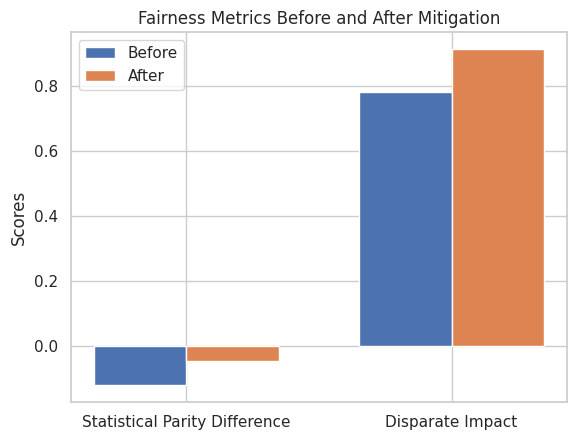

In [37]:
labels = ['Statistical Parity Difference', 'Disparate Impact']
before = [metric.statistical_parity_difference(), metric.disparate_impact()]
after = [metric_post.statistical_parity_difference(), metric_post.disparate_impact()]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, before, width, label='Before')
rects2 = ax.bar(x + width/2, after, width, label='After')

ax.set_ylabel('Scores')
ax.set_title('Fairness Metrics Before and After Mitigation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()
